<a href="https://colab.research.google.com/github/yecatstevir/teambrainiac/blob/main/source/SVM_Group_YA_Whole_brain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Whole Brain Support Vector Machine Training
- Go to 'Runtime' in Colab browser bar, select 'Change Runtime Type', select 'High-RAM' from 'Runtime Shape'. 
- load local pickle file containing all masked, normalized Whole Brain subject data in numpy matrix format
- SVM training per group (subject ids of '100XX-XXXXX' for child and '300XX-XXXXX' for Youth)

### Mount Google Drive and clone repository
- open to source directory

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')#, force_remount = True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/yecatstevir/teambrainiac.git
# Change directory into cloned repo
%cd teambrainiac/source
!ls


fatal: destination path 'teambrainiac' already exists and is not an empty directory.
/content/teambrainiac/source
Access_Load_Data.ipynb		  path_config.py
All_subject_masked_labeled.ipynb  percent_signal_change.ipynb
data				  __pycache__
Images				  SVM_Group_Whole_Brain.ipynb
__init__.py			  SVM.ipynb
Masking.ipynb			  SVM_Whole_Brain.ipynb
Mat_to_Numpy.ipynb		  utils.py
models				  Visualize_Data.ipynb


### Load path_config.py 
- we are already in source so we can just load this file without chanding directory

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving path_config.py to path_config (1).py
User uploaded file "path_config.py" with length 228 bytes


### Load the Whole brain normalized masked all subject 2d pickle file 


#### Import libraries


In [ ]:
# Import libraries
!pip install boto3 nilearn
import pickle
from utils import *
from sklearn.svm import SVC
import numpy as np
import random
#import cv2 as cv
from sklearn.metrics import accuracy_score
#from sklearn.model_selection import cross_val_score
from nilearn.signal import clean
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import tqdm

### Load Data from AWS and create Train/Val/Test splits

In [ ]:
%%time
pkl_file = "whole_brain_all_norm_2d.pkl" # normalized
#pkl_file = 'all_data_dictionary.pkl' #Unnormalized
bool_mat = False
data = access_load_data(pkl_file, bool_mat)

CPU times: user 1min 3s, sys: 1min 28s, total: 2min 32s
Wall time: 2min 4s


In [ ]:
#open path dictionary file to get subject ids
path = "data/data_path_dictionary.pkl"
data_path_dict = open_pickle(path)
subject_ids = data_path_dict['subject_ID']

# Split dataset into young children and older children/young adults
child = subject_ids[:33]
teen_plus = subject_ids[33:]
print("Number of subjects for child and teens", len(child), len(teen_plus))

Number of subjects for child and teens 33 19


#Time Series Cross Validation
## Organize Data Young Adults for Cross Validation
If we are performing cross validation, we need to get the data without custom splitting 

In [ ]:
def data_for_cv(data, group_sub_ids, runs_train, runs_test, norm):
  """
  data: (52 subject data, keys as subject ID for frmi data or labels)
  group_sub_ids: (list of string ID names) either child or teen_plus ids of subjects split on age
  runs_train: int , (which run are we using for the training data)
  runs_test: int, (which run are we using for the test data)
  norm: string, ("RUNS": normalizing separately on each run; "SUBJECT": Normalizing separately by each subject)

  """
  # train and labels
  X = []
  y = []
  # TEST and labels
  Xt = []
  yt = []

  # Get X data from dictionary
  for id_ in group_sub_ids:

    if norm == "RUNS":
      print(f"Normalizing Each Run for group {group_sub_ids}")
      scalar = StandardScaler()
      tr = scalar.fit_transform(data[id_][runs_train])
      X.append(tr)

      scalarT = StandardScaler()
      tst = scalarT.fit_transform(data[id_][runs_test])
      Xt.append(tst)

    elif norm == "SUBJECT":
      print(f"Normalizing Each Subject Data for group {group_sub_ids}")
      scalar = StandardScaler().fit(data[id_][runs_train])
      tr = scalar.transform(data[id_][runs_train])
      X.append(tr)

      tst = scalar.transform(data[id_][runs_test])
      Xt.append(tst)

        
  # Get y labels from dictioanry
    y.append(data[f"{id_}_rt_labels"][runs_train])
    yt.append(data[f"{id_}_rt_labels"][runs_test])

  X_c , y_c, _, _, X_t, y_t = concat_data((X, y), False, (Xt, yt))

  X_full = np.concatenate((X_c, X_t))
  y_full = np.concatenate((y_c, y_t))

  print( "Final X data shape to feed into Time Series Cross Validation", X_full.shape)
  print( "Final y data shape to feed into Time Series Cross Validation", y_full.shape)

  return X_full, y_full






def concat_data(train, val, test):

  if train:
    x, y = train
    X_c = np.concatenate(np.array(x))
    y_c = np.concatenate(np.array(y))
    print( "X train data shape after concantenation", X_c.shape)
    print( "y train data shape after concantenation", y_c.shape)

  if test:
    xtest, ytest = test
    X_t = np.concatenate(np.array(xtest))
    y_t = np.concatenate(np.array(ytest))

    print( "X test data shape after concantenation", X_t.shape)
    print( "y test data shape after concantenation", y_t.shape)

  if val:
    xval, yval = val
    X_v = np.concatenate(np.array(xval))
    y_v = np.concatenate(np.array(yval))

    print( "X val data shape after concantenation", X_v.shape)
    print( "y val data shape after concantenation", y_v.shape)

    return X_c, y_c, X_v, y_v, X_t, y_t


  return X_c, y_c, _, _, X_t, y_t






def time_series_cv(X, y, max_train, test_size, splits): #max_train 2772, n splits = 5, test_size = None

  tscv = TimeSeriesSplit(max_train_size = max_train, n_splits = splits, test_size = test_size) #test_size - 840
  accuracy_ = []
  it = 0

  for train_index, test_index in tqdm(tscv.split(X)):
    it+=1
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
      
    with warnings.catch_warnings():
      warnings.simplefilter("ignore", category=ConvergenceWarning)  
      clf = SVC(C = 5.0, class_weight = 'balanced', max_iter = 1000, random_state = 42)
      print(f"Fitting Classifier for iteration number {it}")
      clf.fit(X_train, y_train)

    print("Predicting...")
    y_pred = clf.predict(X_test)

    # Model Accuracy
    score = accuracy_score(y_test, y_pred)
    print(f"Cross Validation Split {it} Accuracy score:", score)
    accuracy_.append(score)
  
  print("Mean Accuracy: {}".format(np.mean(accuracy_)))


In [ ]:
%%time 

#Function Calls
group_sub_ids = teen_plus
runs_train = 2
runs_test = 3
norm = "SUBJECT"
max_train = 2772
test_size = None
splits = 5

X, y = data_for_cv(data, group_sub_ids, runs_train, runs_test, norm)

time_series_cv(X, y, max_train, test_size, splits)


Child X train data shape after concantenation (2772, 237979)
Child y train data shape after concantenation (2772,)
Child X test data shape after concantenation (2772, 237979)
Child y test data shape after concantenation (2772,)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Cross Validation Split 1:
Accuracy: 0.6352813852813853


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


Cross Validation Split 1:
Accuracy: 0.7196969696969697


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


# Young Adults

In [ ]:
def transform_data(data, group_sub_ids, runs_train, runs_test, norm):
  """
  data.        : (52 subject data, keys as subject ID for frmi data or labels)
  group_sub_ids: (list of string ID names) 
  runs_train.  : int , (which run are we using for the training data)
  runs_test    : int, (which run are we using for the test data)
  norm         : string, ("RUNS": normalizing separately on each run; 
                          "SUBJECT": Normalizing separately by each subject, 
                           fitted to the train data of current subject. Can only 
                           use when all sets utilize the same subject IDs.)

  """

  train_id, val_id, test_id = group_sub_ids

  print(f"Normalizing Each based on {norm}...")
  if norm == "RUNS":
    X, y   = scale_data(data, train_id, runs_train, False, norm)
    Xv, yv = scale_data(data, val_id, runs_train, False, norm)
    Xt, yt = scale_data(data, test_id, runs_test, False, norm)

  elif norm == "SUBJECT":
    print("In order to use SUBJECT NORMALIZATION, be sure Train, Val, Test sets")
    print("All have the same subject IDs, and are using data from separate runs.")
    X, y   = scale_data(data, train_id, runs_train, runs_train, norm)
    Xv, yv = scale_data(data, val_id, runs_train, runs_train, norm)
    Xt, yt = scale_data(data, test_id, runs_test, runs_train, norm)

  X_c , y_c, X_v, y_v, X_t, y_t = concat_data((X, y), (Xv, yv), (Xt, yt))


  print( "Final X Train data shape", X_c.shape)
  print( "Final y Train data shape ", y_c.shape)
  print( "Final X Val data shape", X_v.shape)
  print( "Final y Val data shape ", y_v.shape)
  print( "Final X Test data shape", X_t.shape)
  print( "Final y Test data shape ", y_t.shape)

  return X_c , y_c, X_v, y_v, X_t, y_t # Data ready for SVM






def scale_data(data, sub_ids, run, train_run, norm):
  """
  data      : (52 subject data, keys as subject ID for frmi data or labels)
  sub_ids   : (list of string ID names)
  run       : int, (which run are we using for the current data) 
  train_run : int , (which run are we using for the training data)
  norm      : string, ("RUNS": normalizing separately on each run; 
                       "SUBJECT": Normalizing separately by each subject, 
                        fitted to the train data of current subject. Can only 
                        use when all sets utilize the same subject IDs.)

  """

  X = []
  y = []
  scaler = StandardScaler()

  for id_ in sub_ids:
    if norm == "RUNS":
      x = scaler.fit_transform(data[id_][run])
      X.append(x)

    elif norm == "SUBJECT":
      scaler.fit(data[id_][train_run]) # we want our data to be fit on the training data
      x = scaler.transform(data[id_][run]) #transform on the actual data
      X.append(x)
    y.append(data[f"{id_}_rt_labels"][run])

  return X, y

In [ ]:
# get train, test val data
train_ids = teen_plus[:16]
val_ids = teen_plus[16:20]
test_ids = teen_plus

group_sub_ids = (train_ids, val_ids, test_ids)
runs_train = 1 # grabs the second run
runs_test = 2 # grabds the third run
norm = "RUNS" # Normalizes per run

print("Number of Youth training examples: ", len(train_ids))
print("Number of Youth validation examples: ", len(val_ids))
print("Number of Youth testing examples: ", len(test_ids))
print(len(teen_plus))

# Get all the data we need for SVM
X, y, X_v, y_v, X_t, y_t = transform_data(data, group_sub_ids, runs_train, runs_test, norm)

Number of Youth training examples:  13
Number of Youth validation examples:  3
Number of Youth testing examples:  3


19

# SVM Young Adult

In [ ]:
%%time

model_name = f"group_youth_svm_{id_}"
clfy = SVC(C = 5.0 , class_weight= 'balanced', max_iter = 1000, random_state = 42) #probability = True
clfy.fit(X, y)
f = open("models/%s.pkl"%model_name,"wb")
pickle.dump(clfy, f)
f.close()

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:289: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  ConvergenceWarning,


CPU times: user 6min 37s, sys: 1min 53s, total: 8min 30s
Wall time: 1min 15s


### Validation prediction

In [ ]:
%%time
yvaly_pred = clfy.predict(X_v)

# Model Accuracy
print("Accuracy:", accuracy_score(y_v, yvaly_pred))

Accuracy: 0.7857142857142857
CPU times: user 1.2 ms, sys: 0 ns, total: 1.2 ms
Wall time: 1.22 ms


#### Held Out Test Set Prediction

In [ ]:
%%time
ytesty_pred = clfy.predict(X_t)

# Model Accuracy
print("Accuracy:", accuracy_score(y_t, ytesty_pred))

Accuracy: 0.7658730158730159
CPU times: user 5min 39s, sys: 13min 49s, total: 19min 29s
Wall time: 2min 27s


#### Check Support Vectors

In [ ]:
print("number of support vectors:", len(clfy.support_))
print("indices of support vectors:", clfy.support_)

In [ ]:
clfy.support_vectors_.shape

(997, 237979)

In [ ]:
# number of support vectors for each class
clfy.n_support_

array([512, 485], dtype=int32)

In [ ]:
# Values scaled to fit between -1 and 1 
clfy.dual_coef_

In [ ]:
clf.dual_coef_.shape


(1, 1562)

In [ ]:
clf.support_.shape

#### Create Beta map for Visualization
- Create Alphas

In [ ]:
alphas = np.zeros((1092))
alphas[clf.support_] = clf.dual_coef_ #Load the weights corresponding to where support vectors are 
alphas.shape

(1092,)

In [ ]:
alphas = alphas.reshape(1,-1)
alphas.shape

(1, 1092)

- Create Betas

In [ ]:
mask_data_path = data_path_dict['mask_data'][0]
mask_type_dict = access_load_data(mask_data_path,True)
np_array_mask = mask_type_dict['mask']
print("mask shape:", np_array_mask.shape)

indices_mask = np.where(np_array_mask==1) # gets the indices where the mask is 1, the brain region for x, y, z planes
indices_mask

In [ ]:
bmap = np.dot(alphas, X_trainy)
print("Shape of beta map: ", bmap.shape)
bmap

Shape of beta map:  (1, 237979)


array([[ 352.46328519,  255.78428462,   44.31671587, ..., -193.67628707,
          70.35461177, -190.15088276]])

In [ ]:
bmap2 = np.zeros((79,95,79))

# Grab the areas not masked out of the brain to recreate the brain using highlighted areas
bmap2[indices_mask] = bmap
bmap2

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [ ]:
bmap2.shape

(79, 95, 79)

### Threshold map

In [ ]:
from IPython.core.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf

import ipywidgets as widgets

import requests
import zipfile
import os
import nibabel
from scipy.stats import gamma

In [ ]:
# use some numpy magic to get an array that is nan everywhere that the correlation value is less than .2

# first make a copy of the correlation values
r_thresholded = r_values_as_slice.copy()

# now set any values less than .2 to be equal to nan
r_thresh = .2
r_thresholded[r_thresholded < r_thresh] = np.nan

# Ok now lets visualize all the maps
fig, ax = plt.subplots(1,3,figsize=(18, 6))

# Create the plots
ax[0].imshow(functional_data[:,:,36,10], cmap='gray')
ax[0].set_title('brain slice', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])


ax[1].imshow(r_values_as_slice,  cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])


ax[2].imshow(functional_data[:,:,36,10], cmap='gray')
ax[2].imshow(r_thresholded, cmap='afmhot')
ax[2].set_title('thresholded map (r > ' + str(r_thresh) + ')', fontsize=25)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

IndexError: ignored

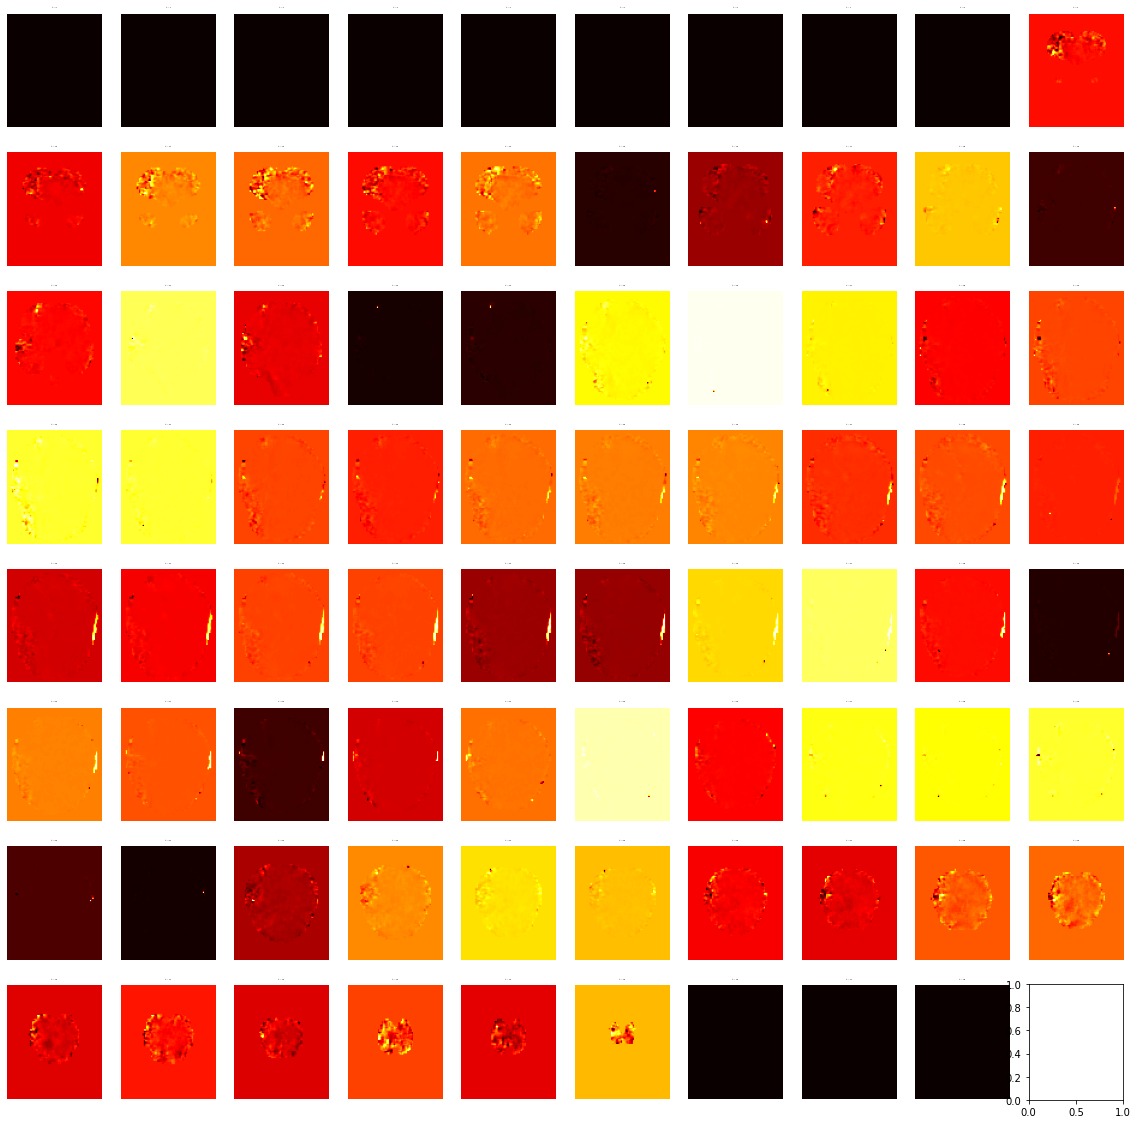

In [ ]:
from matplotlib import patches
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=10, nrows=8, figsize=(20, 20))  # 20 timepoints
# Loop over the first 20 volumes/timepoints
for t, ax in enumerate(axes.flatten()):    
    ax.imshow(bmap2[:, :, t].T, cmap='hot')#, origin='lower')  # index with t!
    rect = patches.Rectangle((38, 20), 2, 2, linewidth=2, edgecolor='r', facecolor='black')
    #ax.add_patch(rect)
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=2)
fig.set_facecolor("gray")
fig.tight_layout()

#### LibSVM

#### OpenCV library
- https://docs.opencv.org/3.4/d1/d73/tutorial_introduction_to_svm.html


In [ ]:
%%time

# Train the SVM using openCV
svm = cv.ml.SVM_create()
svm.setType(cv.ml.SVM_C_SVC)
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setTermCriteria((cv.TERM_CRITERIA_MAX_ITER, 100, 1e-6))
svm.train(X_train, cv.ml.ROW_SAMPLE, y_train)
